# ClimateQ&A
---
Goal of the notebook: Recommended graphs functionality

Inputs of the notebook:

Output of the notebook:


Takeaways:

Questions, thoughts and remarks:
- What do I put for query instruction ?
  - Default is "Represent this sentence for searching relevant passages:"
  - embedding_function = get_embeddings_function(query_instruction="")

## Dependencies and path
Adjust the argument in `sys.path.append` to align with your specific requirements.

In [3]:
import pandas as pd 
import numpy as np
import os

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/dora/climate-question-answering")

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

## 1. Import objects
### 1.1 LLM

In [41]:
from climateqa.engine.llm import get_llm
llm = get_llm(provider="openai")

### 1.2 Embedding

In [42]:
from climateqa.engine.embeddings import get_embeddings_function

embeddings_function = get_embeddings_function()

Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 1.3 Reranker

In [43]:
from climateqa.engine.reranker import get_reranker

reranker = get_reranker("nano")
reranker

INFO:flashrank.Ranker:Downloading ms-marco-TinyBERT-L-2-v2...


Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


ms-marco-TinyBERT-L-2-v2.zip: 100%|██████████| 3.26M/3.26M [00:00<00:00, 40.6MiB/s]


### 1.4 IPCC vectorstore

In [7]:
from climateqa.engine.vectorstore import get_pinecone_vectorstore

vectorstore = get_pinecone_vectorstore(embeddings_function)

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 0.3.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  warn_deprecated(


## 2 Vectorstore

### 2.1 IEA data

In [8]:
from langchain_community.document_loaders import DataFrameLoader
from langchain_chroma import Chroma

df_iea = pd.read_csv("/home/dora/climate-question-answering/data/charts_iea.csv")
df_iea = df_iea.rename(columns={'url': 'returned_content'})
df_iea["doc_id"] = "iea_" + df_iea.index.astype(str)
df_iea["source"] = "IEA"
df_iea.head()

,title,returned_content,sources,notes,appears_in,appears_in_url,doc_id,source
0,Capital requirements for mining to meet demand...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on data from S&P Global and...,Capital requirements are calculated based on c...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_0,IEA
1,"IEA energy transition mineral price index, Jan...",https://www.iea.org/data-and-statistics/charts...,IEA analysis based on Bloomberg and S&P Global.,IEA energy transition minerals price index is ...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_1,IEA
2,Price developments of minerals and metals by c...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on Bloomberg and S&P Global.,"Base metals include iron, aluminium, zinc and ...",Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_2,IEA
3,Capital expenditure on nonferrous metal produc...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on company annual reports a...,"For diversified majors, capex on the productio...",Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_3,IEA
4,"Selected environmental, social and governance ...",https://www.iea.org/data-and-statistics/charts...,IEA analysis based on the latest sustainabilit...,GHG= greenhouse gas. Aggregated data for 25 ma...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_4,IEA


In [9]:
# Load csv file of charts
loader_iea = DataFrameLoader(df_iea, page_content_column='title')
documents_iea = loader_iea.load()
len(documents_iea)

5355

### 2.2 OWID data

In [10]:
df_owid = pd.read_csv("/home/dora/climate-question-answering/data/charts_owid.csv")

# rename column 'embedding' to 'returned_content'
df_owid = df_owid.rename(columns={'embedding': 'returned_content'})
df_owid.head()

df_owid["doc_id"] = "owid_" + df_owid.index.astype(str)
df_owid["source"] = "OWID"
df_owid.head()

,category,title,url,returned_content,subtitle,doc_id,source
0,Access to Energy,Number of people with and without access to cl...,https://ourworldindata.org/grapher/number-with...,"<iframe src=""https://ourworldindata.org/graphe...",Clean cooking fuels and technologies represent...,owid_0,OWID
1,Access to Energy,Number of people without access to clean fuels...,https://ourworldindata.org/grapher/number-with...,"<iframe src=""https://ourworldindata.org/graphe...",Clean cooking fuels and technologies represent...,owid_1,OWID
2,Access to Energy,"People without clean fuels for cooking, by wor...",https://ourworldindata.org/grapher/people-with...,"<iframe src=""https://ourworldindata.org/graphe...",Data source: World Bank,owid_2,OWID
3,Access to Energy,Share of the population without access to clea...,https://ourworldindata.org/grapher/share-of-th...,"<iframe src=""https://ourworldindata.org/graphe...",Access to clean fuels or technologies such as ...,owid_3,OWID
4,Access to Energy,Share with access to electricity vs. per capit...,https://ourworldindata.org/grapher/share-with-...,"<iframe src=""https://ourworldindata.org/graphe...",Having access to electricity is defined in int...,owid_4,OWID


In [11]:
loader_owid = DataFrameLoader(df_owid, page_content_column='title')
documents_owid = loader_owid.load()
len(documents_owid)

2202

### 2.3 Merged Data Loader

In [12]:
from langchain_community.document_loaders.merge import MergedDataLoader

loader_all = MergedDataLoader(loaders=[loader_iea, loader_owid])
documents_all = loader_all.load()
len(documents_all)

7557

In [13]:
documents_all[-1]

Document(page_content='Wildfire area burned by land cover type', metadata={'category': 'Wildfires', 'url': 'https://ourworldindata.org/grapher/annual-burned-area-by-landcover', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/annual-burned-area-by-landcover?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'subtitle': 'Total area of forests, savannas, shrublands/grasslands, croplands, and other land that have been burned as a result of wildfires each year.', 'doc_id': 'owid_2201', 'source': 'OWID'})

### 2.4 Chroma vectorstore

In [14]:
# DO NOT RUN AGAIN (persisted)
vectorstore_graphs = Chroma.from_documents(documents_all, embeddings_function, persist_directory="/home/dora/climate-question-answering/data/vectorstore")

In [15]:
vectorstore_graphs = Chroma(persist_directory="/home/dora/climate-question-answering/data/vectorstore", embedding_function=embeddings_function)

In [17]:
vectorstore_graphs.similarity_search_with_relevance_scores("What is the trend of clean water?")

[(Document(page_content='Share of water bodies with good ambient water quality', metadata={'category': 'Clean Water & Sanitation', 'doc_id': 'owid_742', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Water quality is assessed by means of core physical and chemical parameters that reflect natural water quality. A water body is classified as "good" quality if at least 80% of monitoring values meet target quality levels.', 'url': 'https://ourworldindata.org/grapher/water-bodies-good-water-quality'}),
  0.4695535045145023),
 (Document(page_content='Share of water bodies with good ambient water quality', metadata={'category': 'Water Pollution', 'doc_id': 'owid_2151', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="

## 3. Retriever for recommended graphs

### 3.1 Custom retriever

In [18]:
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents.base import Document
from langchain_core.vectorstores import VectorStore
from langchain_core.callbacks.manager import CallbackManagerForRetrieverRun

from typing import List

class GraphRetriever(BaseRetriever):
    vectorstore:VectorStore
    sources:list = ["IEA", "OWID"] # plus tard ajouter OurWorldInData # faudra integrate avec l'autre retriever
    threshold:float = 0.5
    k_total:int = 10

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:

        # Check if all elements in the list are IEA or OWID
        assert isinstance(self.sources,list)
        assert any([x in ["IEA", "OWID"] for x in self.sources])

        # Prepare base search kwargs
        filters = {}

        filters["source"] = {"$in": self.sources}

        docs = self.vectorstore.similarity_search_with_score(query=query, filter=filters, k=self.k_total)
        
        # Filter if scores are below threshold
        docs = [x for x in docs if x[1] > self.threshold]

        # Add score to metadata
        results = []
        for i,(doc,score) in enumerate(docs):
            doc.metadata["similarity_score"] = score
            doc.metadata["content"] = doc.page_content
            results.append(doc)

        return results

In [21]:
retriever = GraphRetriever(vectorstore=vectorstore_graphs, sources=["OWID"])

In [22]:
retriever.invoke("hydrogen import evolutions")

[Document(page_content='Energy imports and exports', metadata={'category': 'Energy', 'doc_id': 'owid_969', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Energy trade, measured as the percentage of energy use. Positive values indicate a country or region is a net importer of energy. Negative numbers indicate a country or region is a net exporter.', 'url': 'https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use', 'similarity_score': 0.7722017765045166, 'content': 'Energy imports and exports'}),
 Document(page_content='Import of environmentally sound technologies', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_400', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/import-of-environmentally-sound-technologies?tab=

### 3.2 Retriever node

In [56]:
import sys
import os
from contextlib import contextmanager

from climateqa.engine.reranker import rerank_docs



def divide_into_parts(target, parts):
    # Base value for each part
    base = target // parts
    # Remainder to distribute
    remainder = target % parts
    # List to hold the result
    result = []
    
    for i in range(parts):
        if i < remainder:
            # These parts get base value + 1
            result.append(base + 1)
        else:
            # The rest get the base value
            result.append(base)
    
    return result


@contextmanager
def suppress_output():
    # Open a null device
    with open(os.devnull, 'w') as devnull:
        # Store the original stdout and stderr
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        # Redirect stdout and stderr to the null device
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            # Restore stdout and stderr
            sys.stdout = old_stdout
            sys.stderr = old_stderr


def make_graph_retriever_node(vectorstore, reranker, rerank_by_question=True, k_final=15, k_before_reranking=100):

        def retrieve_graphs(state):
            print("---- Retrieving graphs ----")
            
            POSSIBLE_SOURCES = ["IEA", "OWID"]
            questions = state["questions"]
            sources_input = state["sources_input"]

            auto_mode = "auto" in sources_input

            # There are several options to get the final top k
            # Option 1 - Get 100 documents by question and rerank by question
            # Option 2 - Get 100/n documents by question and rerank the total
            if rerank_by_question:
                k_by_question = divide_into_parts(k_final,len(questions))
            
            docs = []
            
            for i,q in enumerate(questions):
                
                sources = q["sources"]
                question = q["question"]
                
                # Sert à rien pour l'instant puisqu'on a auto par défaut et qu'on fait pas de query transformation sur les sources de graphs donc on est toujours en mode auto
                # If auto mode, we use the sources detected by the LLM
                if auto_mode:
                    sources = [x for x in sources if x in POSSIBLE_SOURCES]
                # Otherwise, we use the config
                else:
                    sources = sources_input

                if any([x in POSSIBLE_SOURCES for x in sources]):

                    sources = [x for x in sources if x in POSSIBLE_SOURCES]
                    
                    # Search the document store using the retriever
                    retriever = GraphRetriever(
                        vectorstore = vectorstore,
                        sources = sources,
                        k_total = k_before_reranking,
                        threshold = 0.5,
                        )
                    docs_question = retriever.get_relevant_documents(question)

                    print(f"Docs retrieved: {docs_question}")
                    
                    # Rerank
                    if reranker is not None:
                        with suppress_output():
                            docs_question = rerank_docs(reranker,docs_question,question)
                    else:
                        # Add a default reranking score
                        for doc in docs_question:
                            # doc.metadata["reranking_score"] = doc.metadata["similarity_score"]
                            doc.metadata["reranking_score"] = "No reranking"
                        
                    # If rerank by question we select the top documents for each question
                    if rerank_by_question:
                        docs_question = docs_question[:k_by_question[i]]
                        
                    # Add sources used in the metadata
                    for doc in docs_question:
                        doc.metadata["sources_used"] = sources
                    
                    # Add to the list of docs
                    docs.extend(docs_question)
                    
                # Sorting the list in descending order by rerank_score
                # Then select the top k
                docs = sorted(docs, key=lambda x: x.metadata["reranking_score"], reverse=True)
                docs = docs[:k_final]

            return {"recommended_content": docs}
        
        return retrieve_graphs

In [26]:
# import sys
# import os
# from contextlib import contextmanager

# from climateqa.engine.reranker import rerank_docs


# def divide_into_parts(target, parts):
#     # Base value for each part
#     base = target // parts
#     # Remainder to distribute
#     remainder = target % parts
#     # List to hold the result
#     result = []
    
#     for i in range(parts):
#         if i < remainder:
#             # These parts get base value + 1
#             result.append(base + 1)
#         else:
#             # The rest get the base value
#             result.append(base)
    
#     return result


# @contextmanager
# def suppress_output():
#     # Open a null device
#     with open(os.devnull, 'w') as devnull:
#         # Store the original stdout and stderr
#         old_stdout = sys.stdout
#         old_stderr = sys.stderr
#         # Redirect stdout and stderr to the null device
#         sys.stdout = devnull
#         sys.stderr = devnull
#         try:
#             yield
#         finally:
#             # Restore stdout and stderr
#             sys.stdout = old_stdout
#             sys.stderr = old_stderr



# def make_retriever_node(vectorstore, reranker, rerank_by_question=True, k_final=15, k_before_reranking=100):

#     def retrieve_documents(state):
        
#         POSSIBLE_SOURCES = ["IEA","OWID"]
#         questions = state["questions"]
#         sources_input = state["sources_input"]
        
#         # Sert à rien pour l'instant puisqu'on a des valeurs par défaut et qu'on fait pas de query transformation sur les sources de graphs
#         # Use sources from the user input or from the LLM detection
#         if "sources_input" not in state or state["sources_input"] is None:
#             sources_input = ["auto"]
#         else:
#             sources_input = state["sources_input"]
#         auto_mode = "auto" in sources_input

#         # There are several options to get the final top k
#         # Option 1 - Get 100 documents by question and rerank by question
#         # Option 2 - Get 100/n documents by question and rerank the total
#         if rerank_by_question:
#             k_by_question = divide_into_parts(k_final,len(questions))
        
#         docs = []
        
#         for i,q in enumerate(questions):
            
#             sources = q["sources"]
#             question = q["question"]
            
#             # If auto mode, we use the sources detected by the LLM
#             if auto_mode:
#                 sources = [x for x in sources if x in POSSIBLE_SOURCES]
                
#             # Otherwise, we use the config
#             else:
#                 sources = sources_input
                
#             # Search the document store using the retriever
#             # Configure high top k for further reranking step
#             retriever = GraphRetriever(
#                 vectorstore=vectorstore,
#                 sources = sources,
#                 k_total = k_before_reranking,
#                 threshold = 0.5,
#                 )
#             docs_question = retriever.get_relevant_documents(question)
            
#             # Rerank
#             if reranker is not None:
#                 with suppress_output():
#                     docs_question = rerank_docs(reranker,docs_question,question)
#             else:
#                 # Add a default reranking score
#                 for doc in docs_question:
#                     # doc.metadata["reranking_score"] = doc.metadata["similarity_score"]
#                     doc.metadata["reranking_score"] = "No reranking"
                
#             # If rerank by question we select the top documents for each question
#             if rerank_by_question:
#                 docs_question = docs_question[:k_by_question[i]]
                
#             # Add sources used in the metadata
#             for doc in docs_question:
#                 doc.metadata["sources_used"] = sources
            
#             # Add to the list of docs
#             docs.extend(docs_question)
            
#         # Sorting the list in descending order by rerank_score
#         # Then select the top k
#         docs = sorted(docs, key=lambda x: x.metadata["reranking_score"], reverse=True)
#         docs = docs[:k_final]
        
#         new_state = {"documents": docs}
#         return new_state
    
#     return retrieve_documents

## 4. Graph

### 4.1 Make graph agent

In [66]:
import sys
import os
from contextlib import contextmanager

from langchain.schema import Document
from langgraph.graph import END, StateGraph
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod

from typing_extensions import TypedDict
from typing import List

from IPython.display import display, HTML, Image

from climateqa.engine.chains.answer_chitchat import make_chitchat_node
from climateqa.engine.chains.answer_ai_impact import make_ai_impact_node
from climateqa.engine.chains.query_transformation import make_query_transform_node
from climateqa.engine.chains.translation import make_translation_node
from climateqa.engine.chains.intent_categorization import make_intent_categorization_node
from climateqa.engine.chains.retriever import make_retriever_node
from climateqa.engine.chains.answer_rag import make_rag_node
from climateqa.engine.chains.set_defaults import set_defaults


class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    user_input : str
    language : str
    intent : str
    query: str
    questions : List[dict]
    answer: str
    audience: str
    sources_input: List[str]
    documents: List[Document]
    recommended_content : List[Document]

def search(state):
    return {}

def route_intent(state):
    intent = state["intent"]
    if intent in ["chitchat","esg"]:
        return "answer_chitchat"
    elif intent == "ai_impact":
        return "answer_ai_impact"
    else:
        # Search route
        return "search"
    
def route_translation(state):
    if state["language"].lower() == "english":
        return "transform_query"
    else:
        return "translate_query"
    
def route_based_on_relevant_docs(state,threshold_docs=0.2):
    docs = [x for x in state["documents"] if x.metadata["reranking_score"] > threshold_docs]
    if len(docs) > 0:
        return "answer_rag"
    else:
        return "answer_rag_no_docs"
    

def make_id_dict(values):
    return {k:k for k in values}

def make_graph_agent(llm, vectorstore_ipcc, vectorstore_graphs, reranker, threshold_docs=0.2):
    
    workflow = StateGraph(GraphState)

    # Define the node functions
    categorize_intent = make_intent_categorization_node(llm)
    transform_query = make_query_transform_node(llm)
    translate_query = make_translation_node(llm)
    answer_chitchat = make_chitchat_node(llm)
    answer_ai_impact = make_ai_impact_node(llm)
    retrieve_documents = make_retriever_node(vectorstore_ipcc, reranker)
    retrieve_graphs = make_graph_retriever_node(vectorstore_graphs, reranker)
    answer_rag = make_rag_node(llm, with_docs=True)
    answer_rag_no_docs = make_rag_node(llm, with_docs=False)

    # Define the nodes
    workflow.add_node("set_defaults", set_defaults)
    workflow.add_node("categorize_intent", categorize_intent)
    workflow.add_node("search", search)
    workflow.add_node("transform_query", transform_query)
    workflow.add_node("translate_query", translate_query)
    workflow.add_node("answer_chitchat", answer_chitchat)
    workflow.add_node("answer_ai_impact", answer_ai_impact)
    workflow.add_node("retrieve_graphs", retrieve_graphs)
    workflow.add_node("retrieve_documents", retrieve_documents)
    workflow.add_node("answer_rag", answer_rag)
    workflow.add_node("answer_rag_no_docs", answer_rag_no_docs)

    # Entry point
    workflow.set_entry_point("set_defaults")

    # CONDITIONAL EDGES
    workflow.add_conditional_edges(
        "categorize_intent",
        route_intent,
        make_id_dict(["answer_chitchat","answer_ai_impact","search"])
    )

    workflow.add_conditional_edges(
        "search",
        route_translation,
        make_id_dict(["translate_query","transform_query"])
    )

    workflow.add_conditional_edges(
        "retrieve_documents",
        lambda x : route_based_on_relevant_docs(x,threshold_docs=threshold_docs),
        make_id_dict(["answer_rag","answer_rag_no_docs"])
    )

    # Define the edges
    workflow.add_edge("set_defaults", "categorize_intent")
    workflow.add_edge("translate_query", "transform_query")
    workflow.add_edge("transform_query", "retrieve_graphs")
    workflow.add_edge("retrieve_graphs", "retrieve_documents")
    workflow.add_edge("answer_rag", END)
    workflow.add_edge("answer_rag_no_docs", END)
    workflow.add_edge("answer_chitchat", END)
    workflow.add_edge("answer_ai_impact", END)

    # Compile
    app = workflow.compile()
    return app




def display_graph(app):

    display(
        Image(
            app.get_graph(xray = True).draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

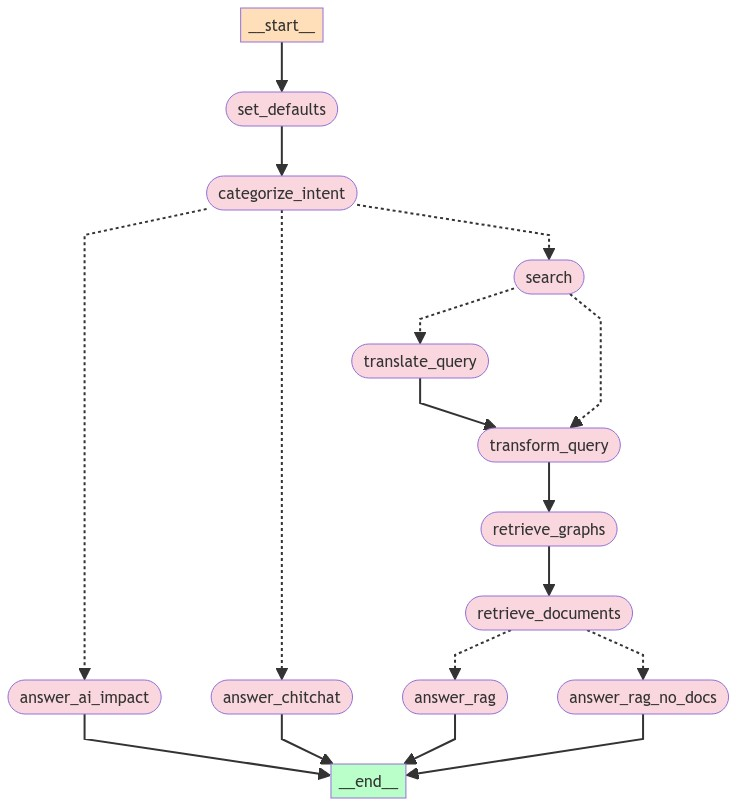

In [67]:
app = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore, vectorstore_graphs=vectorstore_graphs, reranker=reranker)
display_graph(app)

### 4.2 Testing graph agent

In [68]:
output = await app.ainvoke({"user_input": "What are hydrogen imports?"})
output

---- Setting defaults ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---- Retrieving graphs ----
['OpenAlex']


AssertionError: 

In [62]:
async for event in app.astream_events({"user_input": "What are hydrogen imports?"}, version = "v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'user_input': 'What are hydrogen imports?'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '1c50a12d-ef8c-46a1-8cf4-577ebd484fdc', 'metadata': {}}
{'event': 'on_chain_start', 'data': {'input': {'user_input': 'What are hydrogen imports?'}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '4c1b0292-8507-4a83-84ad-f83fe43a3497', 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}}
{'event': 'on_chain_end', 'data': {'output': {'user_input': 'What are hydrogen imports?'}, 'input': {'user_input': 'What are hydrogen imports?'}}, 'run_id': '4c1b0292-8507-4a83-84ad-f83fe43a3497', 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}}
{'event': 'on_chain_start', 'data': {}, 'name': 'set_defaults', 'tags': ['graph:step:1'], 'run_id': 'cb4386bd-a5f8-4c5d-82d0-92ad74efda15', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'set_defau

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'IntentCategorizer'}}, id='run-c1b725cf-ee9e-4f99-89c6-572567e9c93e')}, 'run_id': 'c1b725cf-ee9e-4f99-89c6-572567e9c93e', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-c1b725cf-ee9e-4f99-89c6-572567e9c93e')}, 'run_id': 'c1b725cf-ee9e-4f99-89c6-572567e9c93e', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'intent', 'name': ''}}, id='run-c1b725cf-ee9e-4f99-89c6-572567e9c93e')

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryDecomposition'}}, id='run-33d805b9-4baf-4131-8613-271ee347cc31')}, 'run_id': '33d805b9-4baf-4131-8613-271ee347cc31', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-33d805b9-4baf-4131-8613-271ee347cc31')}, 'run_id': '33d805b9-4baf-4131-8613-271ee347cc31', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'questions', 'name': ''}}, id='run-33d805b9-4baf-4131-8613-271ee347cc31')

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-a86f5f28-6150-4430-84f9-5e9cd97529d4')}, 'run_id': 'a86f5f28-6150-4430-84f9-5e9cd97529d4', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-a86f5f28-6150-4430-84f9-5e9cd97529d4')}, 'run_id': 'a86f5f28-6150-4430-84f9-5e9cd97529d4', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'sources', 'name': ''}}, id='run-a86f5f28-6150-4430-84f9-5e9cd97529d4')}, 'run

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-3a55b8b0-41e8-487c-8165-0e7026d8d1d9')}, 'run_id': '3a55b8b0-41e8-487c-8165-0e7026d8d1d9', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-3a55b8b0-41e8-487c-8165-0e7026d8d1d9')}, 'run_id': '3a55b8b0-41e8-487c-8165-0e7026d8d1d9', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'sources', 'name': ''}}, id='run-3a55b8b0-41e8-487c-8165-0e7026d8d1d9')}, 'run

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-a4553003-567c-4133-9ba2-32a90d84b666')}, 'run_id': 'a4553003-567c-4133-9ba2-32a90d84b666', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-a4553003-567c-4133-9ba2-32a90d84b666')}, 'run_id': 'a4553003-567c-4133-9ba2-32a90d84b666', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'sources', 'name': ''}}, id='run-a4553003-567c-4133-9ba2-32a90d84b666')}, 'run

AssertionError: 